## 零基础实战机器学习

## 第12讲 RNN预测App的激活数走势

作者 黄佳

极客时间专栏链接：https://time.geekbang.org/column/intro/438


问题：根据App的历史激活（即下载后注册用户并使用App）数字，来预测其未来走势

易速鲜花公司拥有过去两年App的日激活数。

通过神经网络中的RNN模型，我们可以对这个时序数据集进行预测。


## 数据的读入和预处理

In [1]:
import numpy as np #导入NumPy
import pandas as pd #导入Pandas 

In [2]:
df_app = pd.read_csv('app.csv', index_col='Date', parse_dates=['Date']) #导入数据
df_app #显示数据

,Activation
Date,
2019-01-01,419
2019-01-02,432
2019-01-03,436
2019-01-04,439
2019-01-05,439
...,...
2021-01-21,916
2021-01-22,925
2021-01-23,926


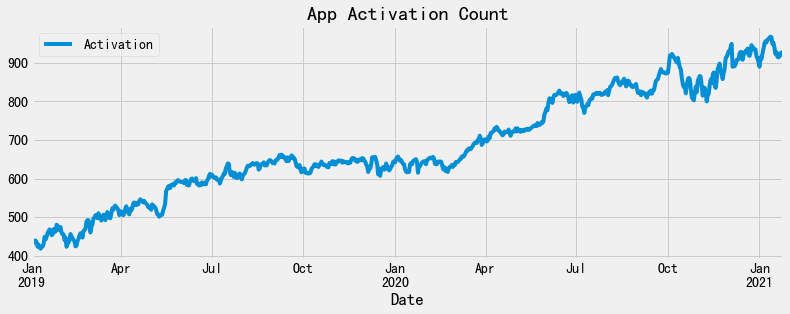

In [3]:
import matplotlib.pyplot as plt #导入matplotlib.pyplot
plt.style.use('fivethirtyeight') #设定绘图风格
df_app["Activation"].plot(figsize=(12,4),legend=True) #绘制激活数
plt.title('App Activation Count') #图题
plt.show() #绘图

### 数据清洗

In [4]:
df_app.isna().sum() #有NaN吗？

Activation    0
dtype: int64

In [5]:
(df_app.Activation < 0).values.any() #有负值吗？

False

### 拆分数据集

In [6]:
# 按照2020年10月1日为界拆分数据集
Train = df_app[:'2020-09-30'].iloc[:,0:1].values #训练集
Test = df_app['2020-10-01':].iloc[:,0:1].values #测试集

In [7]:
Train

array([[419],
       [432],
       [436],
       [439],
       [439],
       [435],
       [423],
       [428],
       [421],
       [418],
       [423],
       [424],
       [431],
       [449],
       [442],
       [449],
       [459],
       [464],
       [468],
       [461],
       [453],
       [455],
       [469],
       [461],
       [463],
       [480],
       [478],
       [467],
       [472],
       [474],
       [459],
       [456],
       [455],
       [440],
       [447],
       [423],
       [430],
       [434],
       [441],
       [456],
       [451],
       [445],
       [441],
       [437],
       [424],
       [426],
       [438],
       [443],
       [452],
       [458],
       [456],
       [447],
       [464],
       [466],
       [469],
       [488],
       [492],
       [492],
       [480],
       [460],
       [475],
       [481],
       [496],
       [499],
       [505],
       [501],
       [497],
       [510],
       [501],
       [495],
       [491],
      

In [8]:
print('训练集的形状是：', Train.shape)
print('测试集的形状是：', Test.shape)

训练集的形状是： (639, 1)
测试集的形状是： (117, 1)


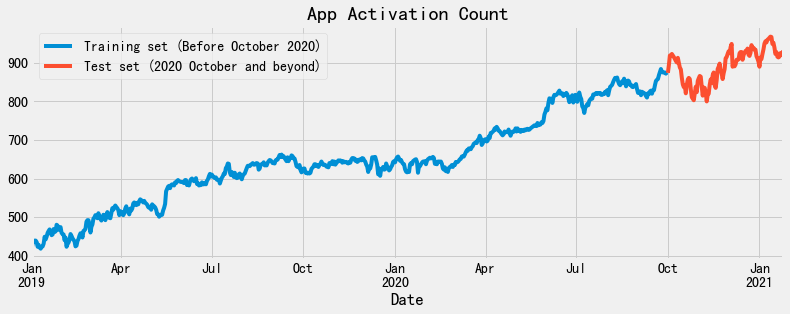

In [9]:
# 以不同颜色为训练集和测试集绘图
df_app["Activation"][:'2020-09-30'].plot(figsize=(12,4),legend=True) #训练集
df_app["Activation"]['2020-10-01':].plot(figsize=(12,4),legend=True) #测试集
plt.legend(['Training set (Before October 2020)','Test set (2020 October and beyond)']) #图例
plt.title('App Activation Count') #图题
plt.show() #绘图

### 特征工程

In [10]:
from sklearn.preprocessing import MinMaxScaler #导入归一化缩放器
Scaler = MinMaxScaler(feature_range=(0,1)) #创建缩放器
Train = Scaler.fit_transform(Train) #拟合缩放器并对训练集进行归一化

### 构建特征集和标签集

In [11]:
# 创建具有 60 个时间步长和 1 个输出的数据结构 - 训练集
X_train = [] #初始化
y_train = [] #初始化
for i in range(60,Train.size): 
    X_train.append(Train[i-60:i,0]) #构建特征
    y_train.append(Train[i,0]) #构建标签
X_train, y_train = np.array(X_train), np.array(y_train) #转换为NumPy数组
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1)) #转换成神经网络所需的张量形状

In [12]:
TrainTest = df_app["Activation"][:] #整体数据
inputs = TrainTest[len(TrainTest)-len(Test) - 60:].values #Test加上前60个时间步
inputs = inputs.reshape(-1,1) #转换形状
inputs  = Scaler.transform(inputs) #归一化
# 创建具有 60 个时间步长和 1 个输出的数据结构 - 测试集
X_test = [] #初始化
y_test = [] #初始化
for i in range(60,inputs.size): 
    X_test.append(inputs[i-60:i,0]) #构建特征
    y_test.append(inputs[i,0]) #构建标签
X_test = np.array(X_test) #转换为NumPy数组
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1)) #转换成神经网络所需的张量形状

## 选择算法

这里我们采用RNN神经网络两种算法

### 神经网络模型

In [13]:
#!pip install keras
#!pip install tensorflow

In [14]:
from keras.models import Sequential #导入序贯模型
from keras.layers import Dense, LSTM #导入全连接层和LSTM层
# from keras.optimizers import SGD
# LSTM网络架构
RNN_LSTM = Sequential() #序贯模型
RNN_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))) #输入层LSTM
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间1层LSTM
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间2层LSTM
RNN_LSTM.add(LSTM(units=50)) #中间3层LSTM
RNN_LSTM.add(Dense(units=1)) #输出层Dense
RNN_LSTM.compile(optimizer='rmsprop',loss='mean_squared_error') #编译网络
RNN_LSTM.summary() #输出神经网络结构信息

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 训练并保存训练历史信息
history = RNN_LSTM.fit(X_train, y_train, # 指定训练集
                  epochs=50,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_split=0.2) #这里直接从训练集数据中拆分验证集，更方便

Epoch 1/50
8/8 [==============================] - 15s 526ms/step - loss: 0.0654 - val_loss: 0.0082
Epoch 2/50
8/8 [==============================] - 2s 230ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 3/50
8/8 [==============================] - 2s 242ms/step - loss: 0.0086 - val_loss: 0.0092
Epoch 4/50
8/8 [==============================] - 2s 245ms/step - loss: 0.0070 - val_loss: 0.0074
Epoch 5/50
8/8 [==============================] - 2s 244ms/step - loss: 0.0058 - val_loss: 0.0100
Epoch 6/50
8/8 [==============================] - 2s 218ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 7/50
8/8 [==============================] - 2s 215ms/step - loss: 0.0080 - val_loss: 0.0044
Epoch 8/50
8/8 [==============================] - 2s 189ms/step - loss: 0.0065 - val_loss: 0.0051
Epoch 9/50
8/8 [==============================] - 2s 205ms/step - loss: 0.0078 - val_loss: 0.0023
Epoch 10/50
8/8 [==============================] - 2s 216ms/step - loss: 0.0064 - val_loss: 0.0025
Epoch 11/50
8/8 [=

In [16]:
def show_history(history): # 显示训练过程中的学习曲线
    loss = history.history['loss'] #训练损失
    val_loss = history.history['val_loss'] #验证损失
    epochs = range(1, len(loss) + 1) #训练轮次
    plt.figure(figsize=(12,4)) # 图片大小
    plt.subplot(1, 2, 1) #子图1
    plt.plot(epochs, loss, 'bo', label='Training loss') #训练损失
    plt.plot(epochs, val_loss, 'b', label='Validation loss') #验证损失
    plt.title('Training and validation loss') #图题
    plt.xlabel('Epochs') #X轴文字
    plt.ylabel('Loss') #Y轴文字
    plt.legend() #图例
    plt.show() #绘图 

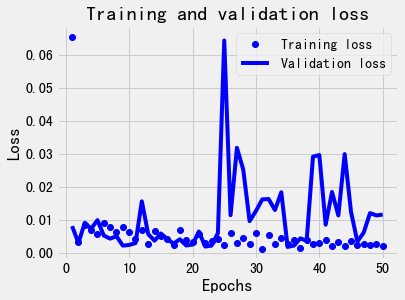

In [17]:
show_history(history) # 调用绘图函数

In [18]:
# 定义绘图函数
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Count') #真值
    plt.plot(predicted, color='blue',label='Predicted Count') #预测值
    plt.title('Flower App Activation Prediction') #图题
    plt.xlabel('Time') #X轴时间
    plt.ylabel('Flower App Activation Count') #Y轴激活数
    plt.legend() #图例
    plt.show() #绘图

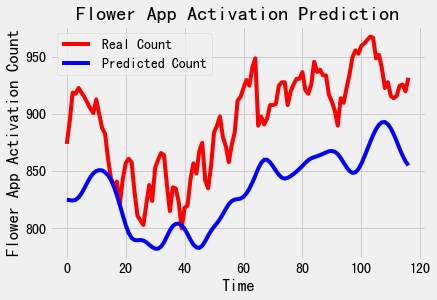

In [19]:
y_pred = RNN_LSTM.predict(X_test) #预测
Pred = Scaler.inverse_transform(y_pred) #反归一化
plot_predictions(Test,Pred) #绘图

In [20]:
import math #导入数学函数
from sklearn.metrics import mean_squared_error
def return_rmse(test,predicted): #定义均方损失函数
    rmse = math.sqrt(mean_squared_error(test, predicted)) #均方损失
    print("MSE损失值 {}.".format(rmse))

In [21]:
return_rmse(y_test,y_pred) #计算均方损失

MSE损失值 0.13970603156988873.
